# Dogs vs. CatsをCNNで解く

## パッケージのインポート

In [1]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt

import os, cv2, random
import numpy as np
import pandas as pd

from matplotlib import ticker
import seaborn as sns

## トレーニング・テストデータの作成

In [2]:
TRAIN_DIR = "./train/"
TEST_DIR = "./test/"

In [3]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [4]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if "dog" in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if "cat" in i]

test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

## 訓練データ（Dogs：1000枚＋Cats：1000枚）とテストデータ（25枚）を抽出

In [5]:
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images = test_images[:25]

## 画像ファイルをNumpy配列（多次元配列）に変換する

In [6]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [7]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0:
            print('Processed {} of {}'.format(i, count))

    return data

In [8]:
train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25


In [9]:
print(train.shape)
print(test.shape)

(2000, 3, 64, 64)
(25, 3, 64, 64)


## ラベル一覧をリスト型変数に格納する

In [10]:
labels = []
for i in train_images:
    if 'dog.' in i:
        labels.append(1)
    else :
        labels.append(0)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Cats and Dogs')

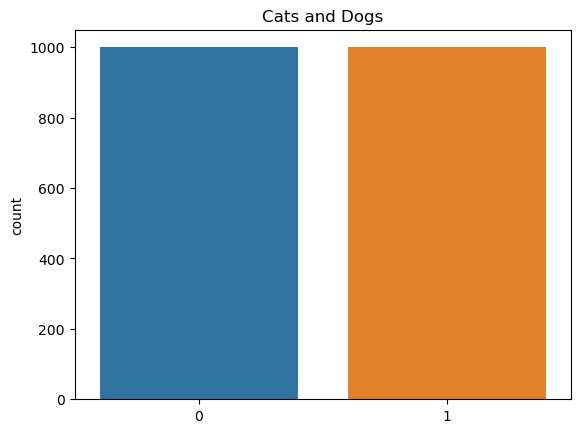

In [11]:
sns.countplot(x=labels)
plt.title('Cats and Dogs')

## 画像データの確認

In [12]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

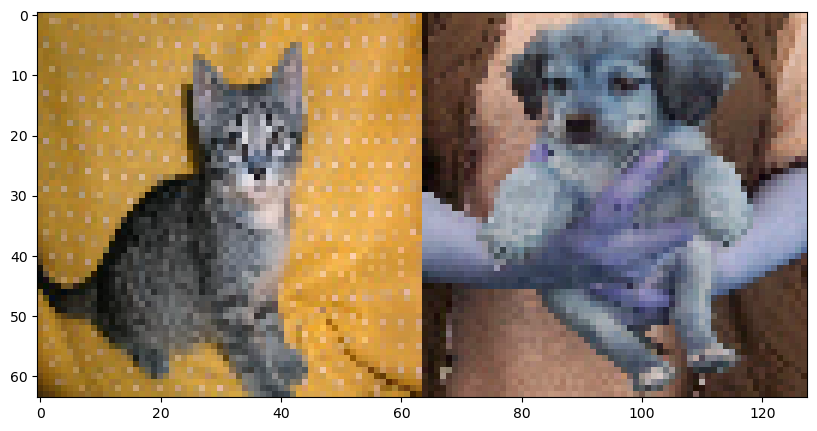

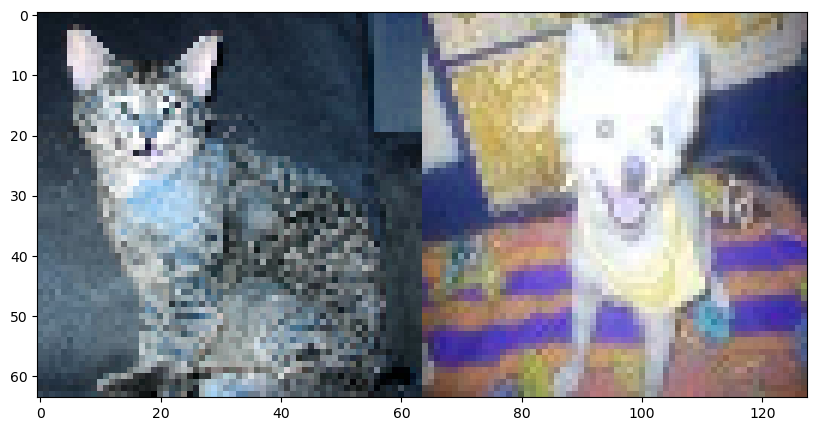

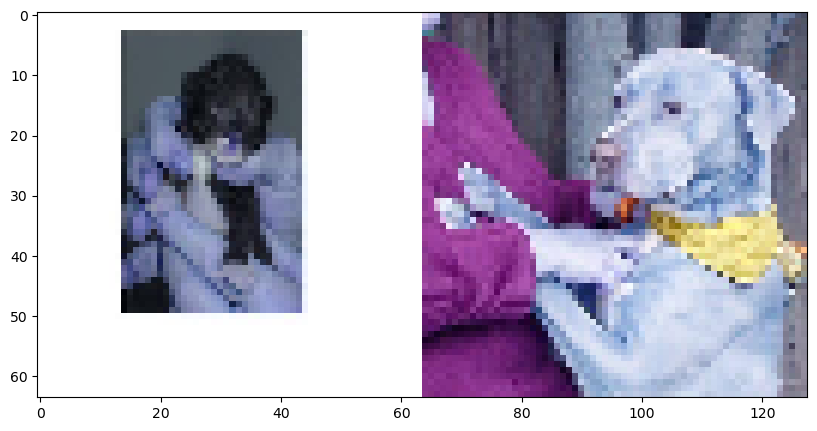

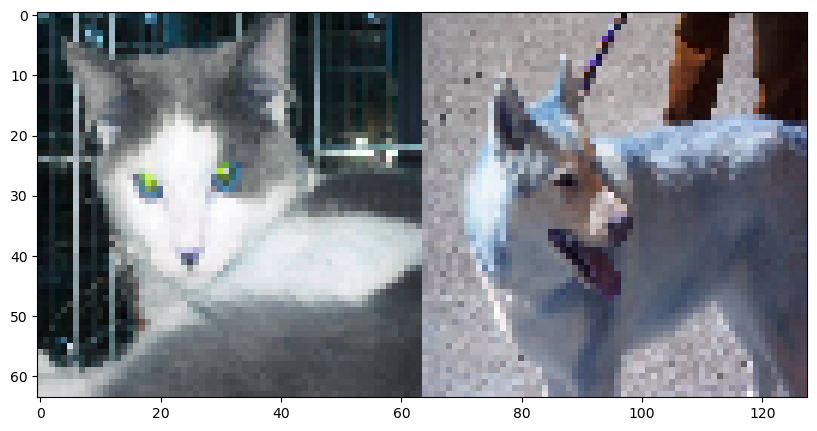

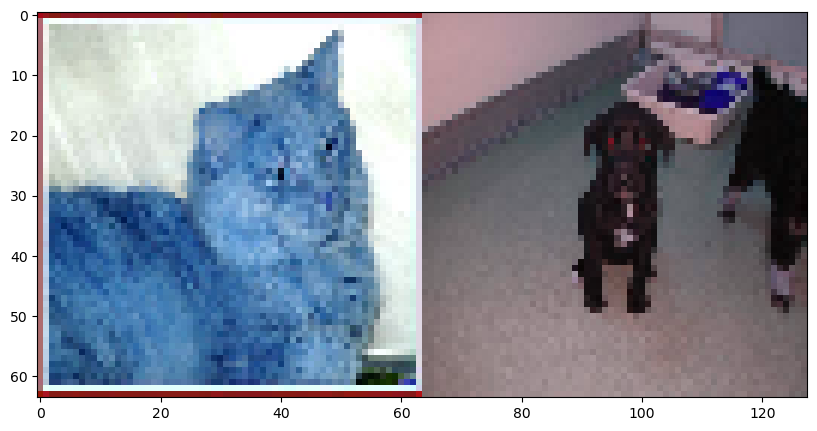

In [13]:
for idx in range(0,5):
    show_cats_and_dogs(idx)

## ピクセル値を平均して画像を生成する

Text(0.5, 1.0, 'Your Average Dog')

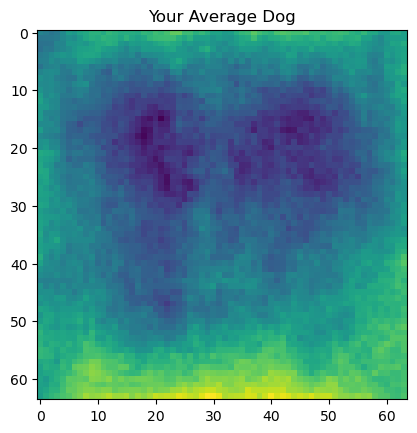

In [14]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train)
                    if labels[i] == 1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title("Your Average Dog")

Text(0.5, 1.0, 'Your Average Cat')

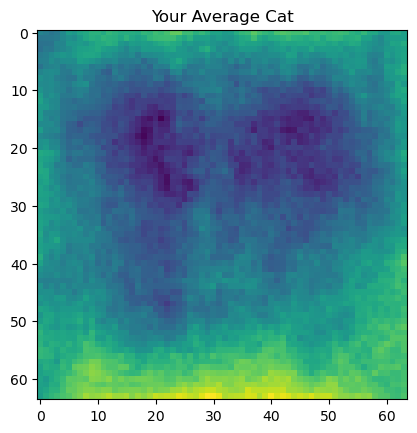

In [15]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train)
                    if labels[i] == 1]).mean(axis=0)
plt.imshow(cat_avg)
plt.title("Your Average Cat")

## CatdogNet-16を定義

In [16]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [17]:
optimizer = Adam()
objective = 'binary_crossentropy'

def catdog():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()

2024-06-17 21:27:43.315693: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-17 21:27:43.315778: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-17 21:27:43.315786: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-17 21:27:43.318122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-17 21:27:43.318461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequenti

## トレーニングを実行

In [18]:
epochs = 10
batch_size = 16
labels = np.array(labels)

#途中経過(loss値)を確認するためのクラス
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

def run_catdog():
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=1, callbacks=history)

    predictions = model.predict(test, verbose=1)
    return predictions, history

predictions, history = run_catdog()

Epoch 1/10


2024-06-17 21:27:48.768889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - accuracy: 0.5104 - loss: 1.6989 - val_accuracy: 0.4740 - val_loss: 0.6936
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.4979 - loss: 0.6936 - val_accuracy: 0.4760 - val_loss: 0.6945
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.4790 - loss: 0.6959 - val_accuracy: 0.4740 - val_loss: 0.6932
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.5232 - loss: 0.6933 - val_accuracy: 0.4760 - val_loss: 0.6937
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.4962 - loss: 0.6942 - val_accuracy: 0.4760 - val_loss: 0.6945
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.5017 - loss: 0.6926 - val_accuracy: 0.4760 - val_loss: 0.6938
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5189 - loss: 0.6930 - val_accuracy: 0.4760 - val_loss: 0.6941
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.4864 - loss: 0.6942 - val_accuracy: 0.476

## 収束状況（loss）を可視化

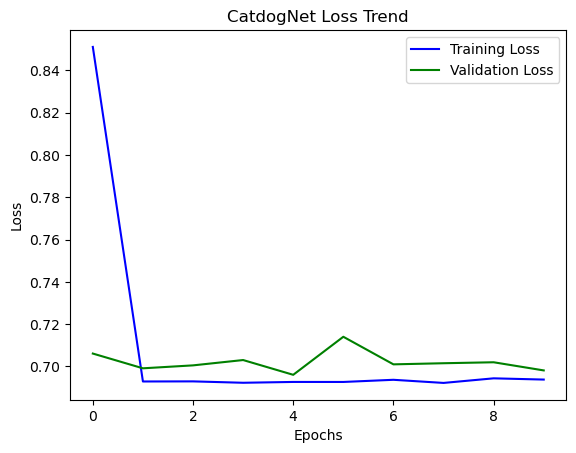

In [19]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('CatdogNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

## 推定結果を可視化

I am 51.36% sure this is a Cat


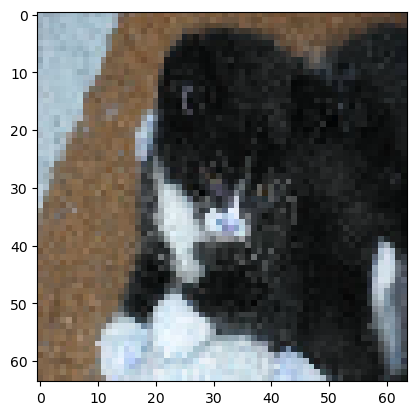

I am 51.37% sure this is a Cat


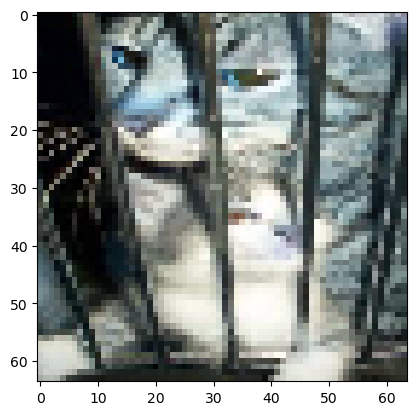

I am 51.36% sure this is a Cat


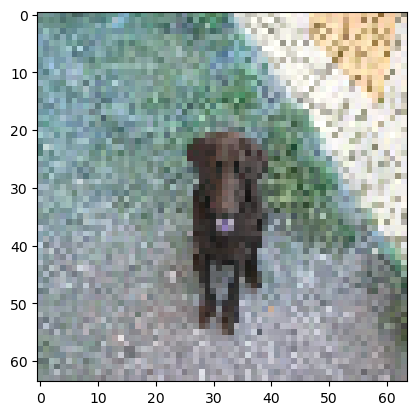

I am 51.35% sure this is a Cat


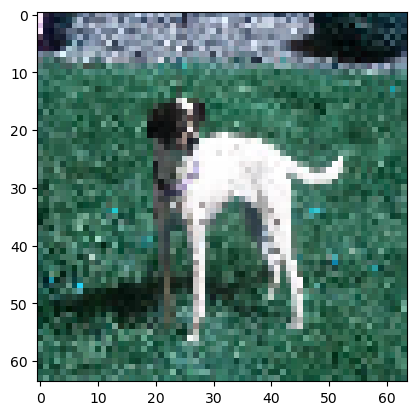

I am 51.37% sure this is a Cat


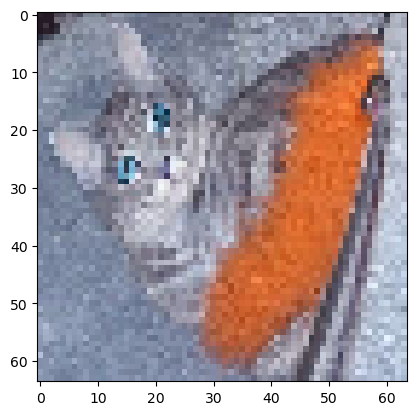

I am 51.37% sure this is a Cat


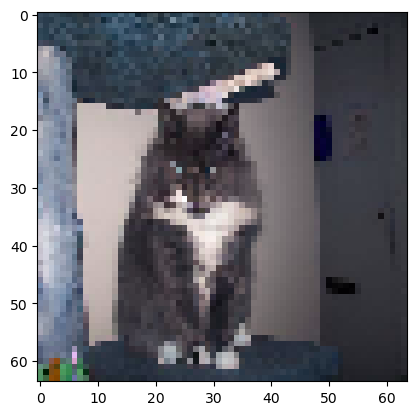

I am 51.36% sure this is a Cat


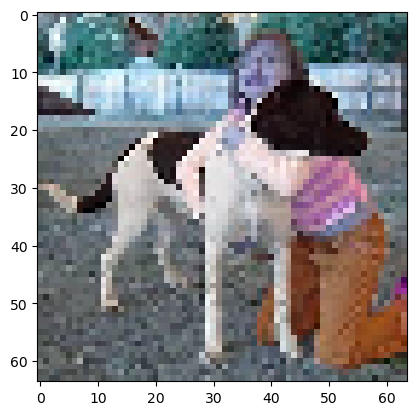

I am 51.37% sure this is a Cat


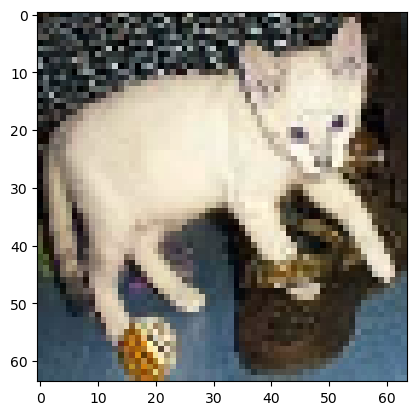

I am 51.38% sure this is a Cat


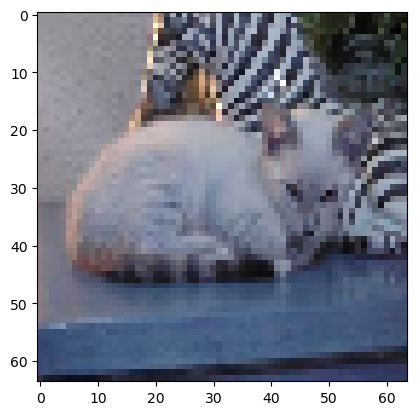

I am 51.37% sure this is a Cat


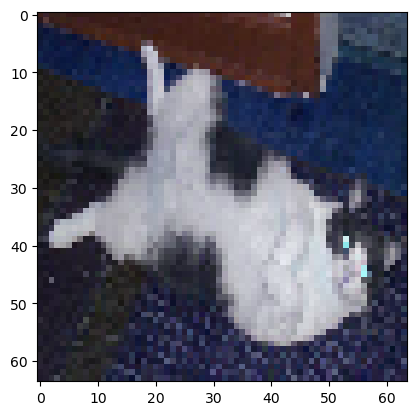

In [19]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1 - predictions[i][0]))

    plt.imshow(test[i].T)
    plt.show()